In [1]:
# !pip install pandas numpy matplotlib seaborn nltk scikit-learn wordcloud networkx folium tqdm

In [2]:
# imports
import json
import re
from ast import literal_eval
from datetime import datetime
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
import networkx as nx
import pycountry

# optional for maps
import folium

In [3]:
# Loading Data

df = pd.read_csv("../data/jobs_raw.csv", dtype=str)
df.shape, df.columns.tolist()
df.head(5).T

,0,1,2,3,4
job_hash,29182168d3c6c29c1ca3dccc7e7f8c50,04537232652c47f8b1bb88aa3440c94d,a902e3c3ab37d9a0da28326d56deefb6,63bf6609a14e232c11b6a6be4fa7d35a,b75ddc1f8e22b15839bb0cc5999a2680
title,Associate Staff Engineer (Java Fullstack),Developer - FullStack (.NET/Angular),Java Developer,"Senior Fullstack Engineer (React,.Net,)",Engineer 2
company,Nagarro,Sopra Steria,Etaclam Techno Services,Version 1,Bread Financial
location,"KA, IN","KA, IN","KA, IN","KA, IN","KA, IN"
description,**Company Description** **We're Nagarro.**\n\n...,**Company Description** **About Sopra Steria**...,**Job Opening: Java Developer (Contract/Full\-...,**Company Description** \n\nVersion 1 has cel...,Every career journey is personal. That's why w...
job_url,https://in.indeed.com/viewjob?jk=f4246be561681b47,https://in.indeed.com/viewjob?jk=dd4b84e8222cc9bc,https://in.indeed.com/viewjob?jk=5468032a765159a5,https://in.indeed.com/viewjob?jk=51267146a1031018,https://in.indeed.com/viewjob?jk=07deaffbb006fbd4
skills_extracted,"[{""skill"": ""java"", ""category"": ""programming""},...","[{""skill"": ""javascript"", ""category"": ""programm...","[{""skill"": ""java"", ""category"": ""programming""},...","[{""skill"": ""javascript"", ""category"": ""programm...","[{""skill"": ""java"", ""category"": ""programming""},..."
skill_count,11,13,6,18,9
top_skills,"java, react, spring, elasticsearch, cassandra","javascript, typescript, angular, jquery, html","java, spring boot, aws, docker, kubernetes","javascript, typescript, react, html5, css3","java, javascript, react, angular, aws"
min_salary,NaN,NaN,NaN,NaN,NaN


In [4]:
# Basic Cleaning

# strip whitespace from column names and values
df.columns=df.columns.str.strip()
df = df.applymap(lambda x:x.strip() if isinstance(x, str) else x)

# parse date columns
for col in ['posted_date', 'scraped_date']:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors = 'coerce')

# convert skill_count to numeric
if 'skill_count' in df.columns:
    df['skill_count'] = pd.to_numeric(df['skill_count'], errors = 'coerce')
    

# filling null values
df['company'] = df['company'].fillna('Unknown')

C:\Users\alokd\AppData\Local\Temp\ipykernel_39208\2788119927.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x:x.strip() if isinstance(x, str) else x)


In [5]:
# Transforming Location to City, State

# function to get full state name from code
def get_state_name(code):
    try:
        subdiv = pycountry.subdivisions.get(code=f"IN-{code.strip().upper()}")
        return subdiv.name if subdiv else code
    except:
        return code

# function to split location and handle "KA, IN" format
def split_location(loc):
    if pd.isna(loc): 
        return (None, None, None)
    
    s = loc.strip()
    
    # handle "KA, IN" style
    if re.match(r'^[A-Z]{2,3}\s*,\s*[A-Z]{2}$', s):
        st_code, country = [p.strip() for p in s.split(',')]
        state_full = get_state_name(st_code)
        return (None, state_full, country.title())
    
    # general split by commas
    if ',' in s:
        parts = [p.strip() for p in s.split(',')]
        if len(parts) == 2:
            city, country = parts
            return (city.title(), None, country.title())
        elif len(parts) >= 3:
            return (parts[0].title(), parts[1].title(), parts[2].title())
    
    return (s.title(), None, None)

# apply to dataframe
df[['city', 'state', 'country']] = df['location'].apply(lambda x: pd.Series(split_location(x)))

df[['location', 'city', 'state', 'country']].head()

,location,city,state,country
0,"KA, IN",None,Karnātaka,In
1,"KA, IN",None,Karnātaka,In
2,"KA, IN",None,Karnātaka,In
3,"KA, IN",None,Karnātaka,In
4,"KA, IN",None,Karnātaka,In


In [6]:
# Filling missing city and states

# City → State mapping
CITY_STATE_MAP = {
    "Bangalore": "Karnataka",
    "Hyderabad": "Telangana",
    "Pune": "Maharashtra",
    "Chennai": "Tamil Nadu",
    "Mumbai": "Maharashtra",
    "Gurugram": "Haryana",
    "Noida": "Uttar Pradesh",
    "Delhi": "Delhi",
    "Kolkata": "West Bengal"
}

# --- Function to fill missing city/state ---
def fill_city_state(row):
    # If city and state are already present, keep them
    if pd.notna(row['city']) and pd.notna(row['state']):
        return row
    
    # Extract from search_location (like "Bangalore, India")
    if pd.notna(row['search_location']):
        city = row['search_location'].split(',')[0].strip().title()
        state = CITY_STATE_MAP.get(city, None)
        row['city'] = city
        row['state'] = state
    
    # Always ensure country is India if missing or 'In'
    if pd.isna(row['country']) or row['country'].strip().lower() in ['in', 'india', '']:
        row['country'] = 'India'
    
    return row

# Apply the function to every row
df = df.apply(fill_city_state, axis=1)

# ✅ Verify result
print(df[['search_location', 'city', 'state', 'country']].head(10))


    search_location       city      state country
0  Bangalore, India  Bangalore  Karnataka   India
1  Bangalore, India  Bangalore  Karnataka   India
2  Bangalore, India  Bangalore  Karnataka   India
3  Bangalore, India  Bangalore  Karnataka   India
4  Bangalore, India  Bangalore  Karnataka   India
5  Bangalore, India  Bangalore  Karnataka   India
6  Bangalore, India  Bangalore  Karnataka   India
7  Bangalore, India  Bangalore  Karnataka   India
8  Bangalore, India  Bangalore  Karnataka   India
9  Bangalore, India  Bangalore  Karnataka   India


In [7]:
# Removing abbreviation from cities

# State abbreviation mapping (only for the states in your data)
state_abbreviations = {
    # Karnataka
    'Ka': 'Karnataka',
    'KA': 'Karnataka',
    'ka': 'Karnataka',
    
    # Telangana
    'Ts': 'Telangana',
    'TS': 'Telangana',
    'ts': 'Telangana',
    
    # Maharashtra
    'Mh': 'Maharashtra',
    'MH': 'Maharashtra',
    'mh': 'Maharashtra',
    
    # Tamil Nadu
    'Tn': 'Tamil Nadu',
    'TN': 'Tamil Nadu',
    'tn': 'Tamil Nadu',
    
    # Haryana
    'Hr': 'Haryana',
    'HR': 'Haryana',
    'hr': 'Haryana',
    
    # Uttar Pradesh
    'Up': 'Uttar Pradesh',
    'UP': 'Uttar Pradesh',
    'up': 'Uttar Pradesh',
    
    # Delhi
    'Dl': 'Delhi',
    'DL': 'Delhi',
    'dl': 'Delhi',
    
    # West Bengal
    'Wb': 'West Bengal',
    'WB': 'West Bengal',
    'wb': 'West Bengal'
}

# Replace abbreviations in the original dataframe
df['state'] = df['state'].replace(state_abbreviations)

# Display results
print("✅ State abbreviations replaced successfully!\n")
print("Unique states in dataframe:")
print(sorted(df['state'].unique()))
print(f"\nTotal records: {len(df)}")
print(f"\nState distribution:")
print(df['state'].value_counts())

✅ State abbreviations replaced successfully!

Unique states in dataframe:
['Delhi', 'Haryana', 'Karnataka', 'Maharashtra', 'Tamil Nadu', 'Telangana', 'Uttar Pradesh', 'West Bengal']

Total records: 3381

State distribution:
state
Maharashtra      844
Karnataka        474
Haryana          439
Tamil Nadu       404
Telangana        399
Delhi            359
West Bengal      355
Uttar Pradesh    107
Name: count, dtype: int64


In [8]:
# Now dropping extra columns:
df = df.drop(columns=['search_location', 'country', 'location'])
df.head(5)

,job_hash,title,company,description,job_url,skills_extracted,skill_count,top_skills,min_salary,max_salary,currency,posted_date,site_source,search_term,scraped_date,city,state
0,29182168d3c6c29c1ca3dccc7e7f8c50,Associate Staff Engineer (Java Fullstack),Nagarro,**Company Description** **We're Nagarro.**\n\n...,https://in.indeed.com/viewjob?jk=f4246be561681b47,"[{""skill"": ""java"", ""category"": ""programming""},...",11,"java, react, spring, elasticsearch, cassandra",NaN,NaN,NaN,2025-10-23,indeed,SQL Developer,2025-10-23 18:22:02.980063,Bangalore,Karnataka
1,04537232652c47f8b1bb88aa3440c94d,Developer - FullStack (.NET/Angular),Sopra Steria,**Company Description** **About Sopra Steria**...,https://in.indeed.com/viewjob?jk=dd4b84e8222cc9bc,"[{""skill"": ""javascript"", ""category"": ""programm...",13,"javascript, typescript, angular, jquery, html",NaN,NaN,NaN,2025-10-23,indeed,SQL Developer,2025-10-23 18:22:03.056440,Bangalore,Karnataka
2,a902e3c3ab37d9a0da28326d56deefb6,Java Developer,Etaclam Techno Services,**Job Opening: Java Developer (Contract/Full\-...,https://in.indeed.com/viewjob?jk=5468032a765159a5,"[{""skill"": ""java"", ""category"": ""programming""},...",6,"java, spring boot, aws, docker, kubernetes",NaN,NaN,NaN,2025-10-23,indeed,SQL Developer,2025-10-23 18:22:03.124911,Bangalore,Karnataka
3,63bf6609a14e232c11b6a6be4fa7d35a,"Senior Fullstack Engineer (React,.Net,)",Version 1,**Company Description** \n\nVersion 1 has cel...,https://in.indeed.com/viewjob?jk=51267146a1031018,"[{""skill"": ""javascript"", ""category"": ""programm...",18,"javascript, typescript, react, html5, css3",NaN,NaN,NaN,2025-10-23,indeed,SQL Developer,2025-10-23 18:22:03.214881,Bangalore,Karnataka
4,b75ddc1f8e22b15839bb0cc5999a2680,Engineer 2,Bread Financial,Every career journey is personal. That's why w...,https://in.indeed.com/viewjob?jk=07deaffbb006fbd4,"[{""skill"": ""java"", ""category"": ""programming""},...",9,"java, javascript, react, angular, aws",NaN,NaN,NaN,2025-10-23,indeed,SQL Developer,2025-10-23 18:22:03.349424,Bangalore,Karnataka


In [9]:
# Filtering data science jobs

# Creating the filter:
exclude_keywords = [
    'java', 'react', 'angular', '.net', 'developer', 'fullstack', 
    'full stack', 'frontend', 'backend', 'ios', 'android', 'qa', 'test',
    'software engineer', 'spring', 'dot net', 'php', 'node', 'oracle developer',
    'sap', 'hcm', 'web developer', 'c++', 'network', 'support engineer'
]

def contains_exclude(title):
    if pd.isna(title):
        return False
    title_lower = title.lower()
    # escape each keyword to avoid regex errors
    return any(re.search(rf"\b{re.escape(k.lower())}\b", title_lower) for k in exclude_keywords)

In [10]:
# Applying the filter:

# Create a boolean mask
df['exclude_job'] = df['title'].apply(contains_exclude)

# Keep only rows where exclude_job is False
data_jobs_df = df[~df['exclude_job']].copy()

# Keep only the data-related jobs
df = df[~df['exclude_job']].copy()

# Drop the temporary helper column
df.drop(columns=['exclude_job'], inplace=True)

# Check the result
print("Final dataset shape:", df.shape)
df['title'].sample(20, random_state=1).tolist()

Final dataset shape: (2575, 17)


['AI / ML Engineer',
 'Data Science & Analytics Trainer',
 'Python Automation Engineer - Software Quality Assurance',
 "Data Scientist - Recommender S/m's",
 '2900 - Senior Data Analyst',
 'Bilingual Business Analyst',
 'KPMG India, Data Privacy, Analyst',
 'Big Data Consultant, Data & Analytics',
 'Data Scientist [T500-20970]',
 'ML ops Engineer',
 'Business Analyst',
 'Business Systems Analyst - Enterprise Data',
 'Agentic AI Engineer',
 'Senior Quality Analyst',
 'Data Science',
 'Business Analyst',
 'AI Engineer',
 'System IT Engineer',
 'Sr. Business Analyst',
 'Sr Business Systems Analyst - Chennai']

In [11]:
# Derive seniority from title:
def infer_seniority(title):
    if pd.isna(title): return 'Unknown'
    t = title.lower()
    if any(k in t for k in ['intern','internship']): return 'Intern'
    if any(k in t for k in ['junior','jr.','júnior']): return 'Junior'
    if any(k in t for k in ['associate','associate staff']): return 'Associate'
    if any(k in t for k in ['senior','sr.','sr']): return 'Senior'
    if any(k in t for k in ['lead','principal','staff','architect']): return 'Lead/Principal'
    if any(k in t for k in ['manager','director','head','vp','vice']): return 'Manager+'
    return 'Mid'

df['seniority'] = df['title'].apply(infer_seniority)
df['seniority'].value_counts()


seniority
Mid               1697
Senior             361
Lead/Principal     156
Associate          141
Manager+           123
Intern              71
Junior              26
Name: count, dtype: int64

In [12]:
# Skill frequency and top skills

skill_counter = Counter()

# Safely split comma-separated strings into lists before counting
df['top_skills'].dropna().apply(
    lambda x: skill_counter.update([s.strip().lower() for s in str(x).split(',') if s.strip()])
)

# Get top 50 most common skills
top_skills = skill_counter.most_common(50)

# Convert to DataFrame for easy viewing
top_skills_df = pd.DataFrame(top_skills, columns=['skill', 'count'])

# Show top 20
print(top_skills_df.head(20))



                      skill  count
0                     teams    468
1                        ai    446
2                    python    417
3                        ml    229
4                       aws    215
5                     azure    178
6          machine learning    178
7              data science    176
8                      java    120
9                  power bi    114
10                       go    107
11           data analytics    107
12  artificial intelligence     95
13                  tableau     94
14             google cloud     79
15                   oracle     58
16                     jira     53
17               kubernetes     37
18                     less     33
19               confluence     33


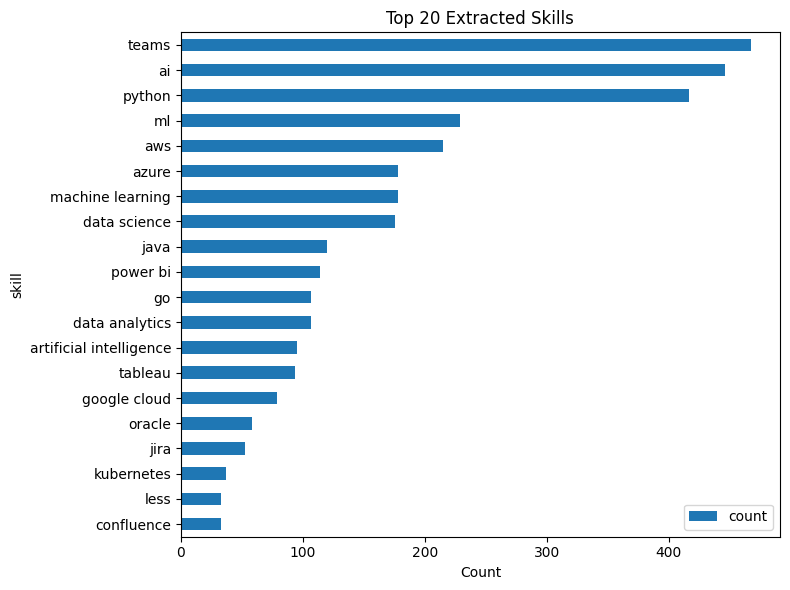

In [13]:
# Top 20 Skills
skill_df = pd.DataFrame(top_skills[:20], columns=['skill','count']).set_index('skill')
skill_df.plot.barh(figsize=(8,6))
plt.title("Top 20 Extracted Skills")
plt.gca().invert_yaxis()
plt.xlabel("Count")
plt.tight_layout()


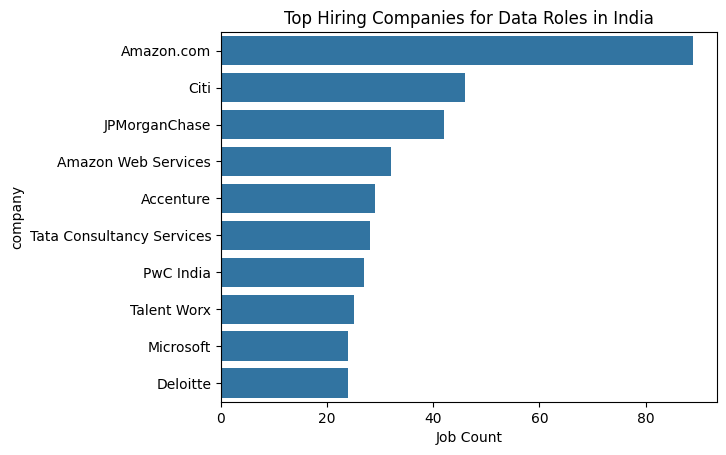

In [14]:
# Top Hiring Companies

top_companies = df['company'].value_counts().head(10)
sns.barplot(y=top_companies.index, x=top_companies.values)
plt.title("Top Hiring Companies for Data Roles in India")
plt.xlabel("Job Count")
plt.show()

C:\Users\alokd\AppData\Local\Temp\ipykernel_39208\2743541293.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=city_jobs.index, x=city_jobs.values, palette="viridis")


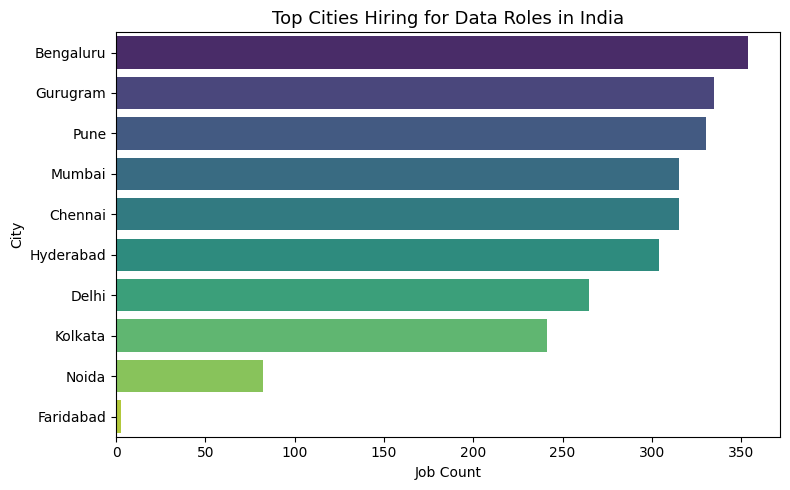

In [15]:
# Jobs by City or State

# city normalization mapping 
city_map = {
    'bangalore': 'Bengaluru',
    'bengaluru east': 'Bengaluru',
    'bangalore urban': 'Bengaluru',
    'gurgaon': 'Gurugram',
    'new delhi': 'Delhi',
    'delhi cantonment': 'Delhi',
    'south delhi': 'Delhi',
    'south delhi': 'Delhi',
    'patel nagar': 'Delhi',
    'navi mumbai': 'Mumbai',
}

# making a temp Series of cleaned city names
city_jobs = (
    df['city']
    .dropna()
    .str.strip()
    .str.lower()
    .replace(city_map)
    .str.title()
    .value_counts()
    .head(10)
)

# plot
plt.figure(figsize=(8,5))
sns.barplot(y=city_jobs.index, x=city_jobs.values, palette="viridis")
plt.title("Top Cities Hiring for Data Roles in India", fontsize=13)
plt.xlabel("Job Count")
plt.ylabel("City")
plt.tight_layout()
plt.show()

In [16]:
city_jobs

city
Bengaluru    354
Gurugram     335
Pune         330
Mumbai       315
Chennai      315
Hyderabad    304
Delhi        265
Kolkata      241
Noida         82
Faridabad      3
Name: count, dtype: int64

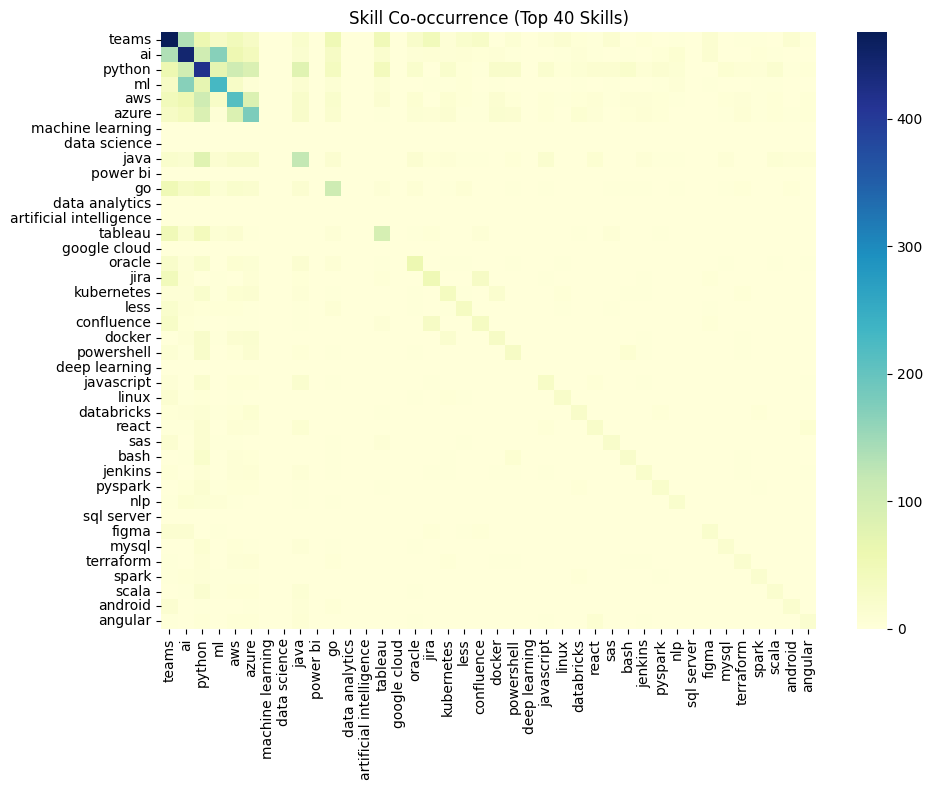

In [17]:
# Skill co-occurrence matrix:

# --- Prepare top skills ---
topN = [s for s, _ in top_skills[:40]]

# Convert each skill list into a space-separated string (for CountVectorizer)
skill_strs = df['top_skills'].dropna().apply(lambda x: " ".join([s.strip().lower() for s in x.split(',') if s.strip()]))

# --- Build co-occurrence matrix ---
vec = CountVectorizer(token_pattern=r"(?u)\b[a-zA-Z0-9\+\-#\.]+\b", vocabulary=topN)
X = vec.fit_transform(skill_strs)
cooc_matrix = (X.T @ X).toarray()

# Create dataframe for readability
cooc_df = pd.DataFrame(cooc_matrix, index=topN, columns=topN)

# --- Plot heatmap ---
plt.figure(figsize=(10, 8))
sns.heatmap(cooc_df, cmap='YlGnBu', annot=False)
plt.title("Skill Co-occurrence (Top 40 Skills)")
plt.tight_layout()
plt.show()


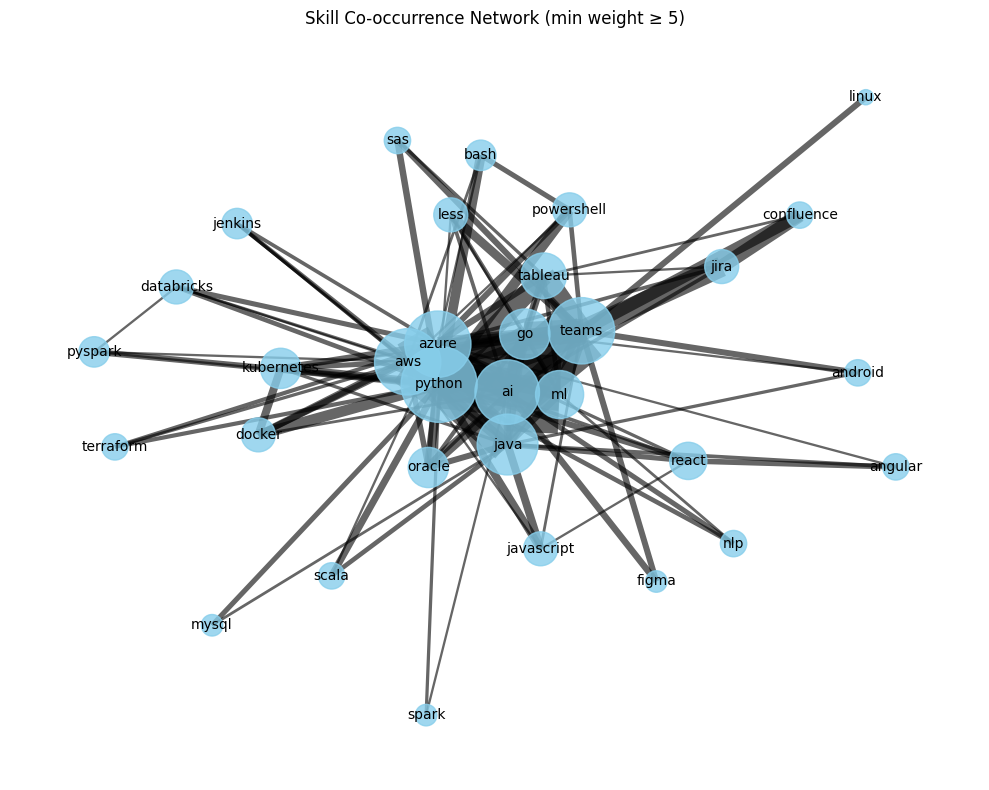

In [18]:

# Top Skill Co-occurrence Network (threshold ≥ 5)

# --- Build co-occurrence network ---
G = nx.Graph()
threshold = 5  # only show edges with at least this many co-occurrences

for i, skill_i in enumerate(topN):
    for j, skill_j in enumerate(topN):
        if j > i and cooc_df.iat[i, j] >= threshold:
            G.add_edge(skill_i, skill_j, weight=cooc_df.iat[i, j])

# --- Draw network ---
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, k=0.5, seed=42)  # stable layout
node_sizes = [G.degree(n) * 120 for n in G.nodes()]
edge_widths = [d['weight'] / 2 for (_, _, d) in G.edges(data=True)]

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='skyblue', alpha=0.8)
nx.draw_networkx_edges(G, pos, width=[d['weight']/3 for (_,_,d) in G.edges(data=True)],
                       alpha=0.6)
nx.draw_networkx_labels(G, pos, font_size=10)

plt.title(f"Skill Co-occurrence Network (min weight ≥ {threshold})")
plt.axis('off')
plt.tight_layout()
plt.show()

In [19]:
# Hiring Trend Over Time 

df['posted_date_clean'] = pd.to_datetime(df['posted_date_clean'])
trend = df.groupby(df['posted_date_clean'].dt.to_period('M')).size()

trend.plot(kind='line', marker='o', title='Job Postings Trend Over Time')
plt.ylabel('Number of Jobs')
plt.show()


KeyError: 'posted_date_clean'

Text(0.5, 1.0, 'Days since posting')

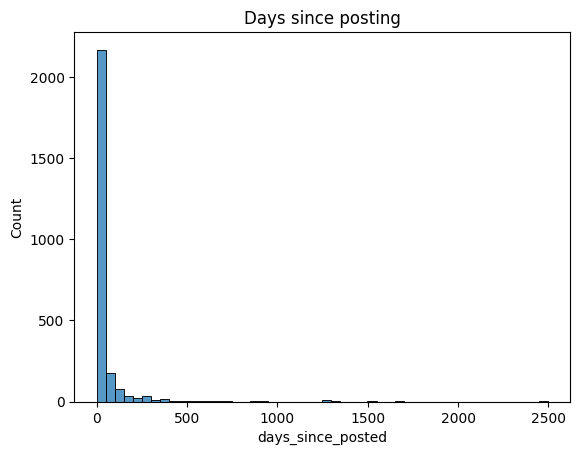

In [ ]:
# Distribution of days_since_posted

today = pd.to_datetime('now')
df['days_since_posted'] = (today - df['posted_date_clean']).dt.days
df['days_since_posted'].describe()
sns.histplot(df['days_since_posted'].dropna(), bins=50)
plt.title("Days since posting")


In [ ]:
# Removing empty columns:
# df['salary_mid'].isna().sum()
# df['max_salary'].isna().sum()
# df['min_salary'].isna().sum()
# df['currency'].isna().sum()
# df = df.drop(columns=[ 'salary_mid', 'max_salary', 'min_salary','currency'])


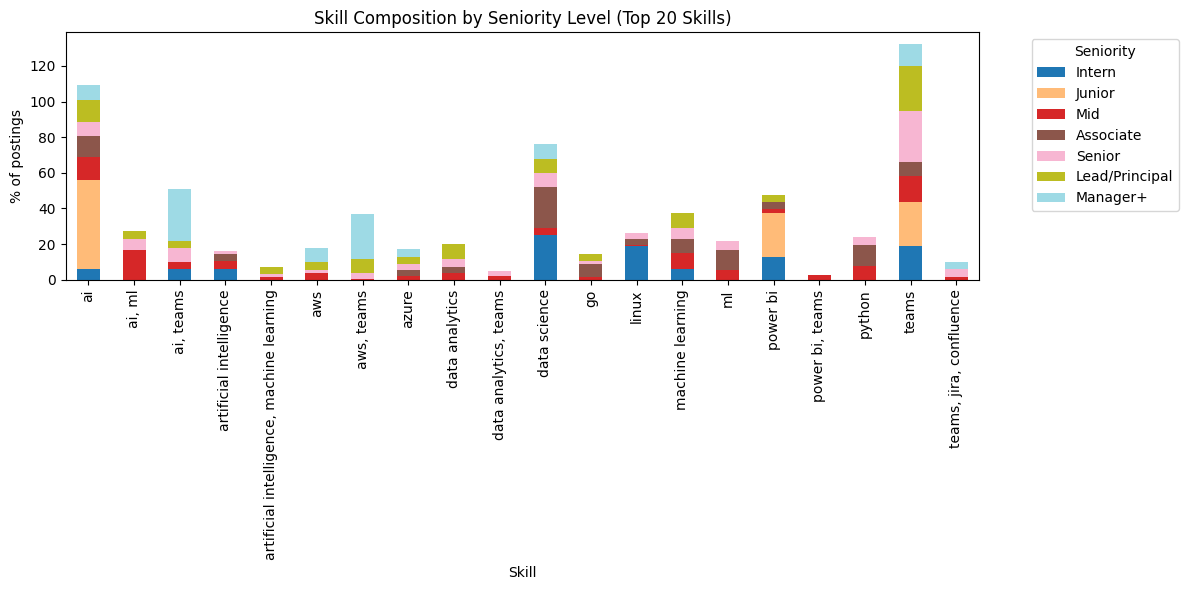

In [ ]:
# Skill Composition by Seniority Level
skill_seniority.T.plot(
    kind='bar',
    stacked=True,
    figsize=(12,6),
    colormap='tab20'
)
plt.title("Skill Composition by Seniority Level (Top 20 Skills)")
plt.ylabel("% of postings")
plt.xlabel("Skill")
plt.legend(title="Seniority", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
# Creating Indian State Choropleth Map

# Aggregate data by state
state_counts = df.groupby('state').size().reset_index(name='job_count')

# Calculate percentage of total positions
total_jobs = state_counts['job_count'].sum()
state_counts['percentage'] = (state_counts['job_count'] / total_jobs * 100).round(2)

# Load India GeoJSON (states boundaries)
india_geojson_url = 'https://gist.githubusercontent.com/jbrobst/56c13bbbf9d97d187fea01ca62ea5112/raw/e388c4cae20aa53cb5090210a42ebb9b765c0a36/india_states.geojson'
india_geojson = requests.get(india_geojson_url).json()

# Extract state names from GeoJSON for reference
geojson_states = [feature['properties']['ST_NM'] for feature in india_geojson['features']]
print("States in GeoJSON:", sorted(geojson_states))
print("\nStates in your data:", sorted(state_counts['state'].unique()))

# Auto-match states using fuzzy matching
from difflib import get_close_matches

def match_state_name(state, geojson_states):
    """Automatically match state names"""
    # First try exact match
    if state in geojson_states:
        return state
    
    # Try case-insensitive match
    for gs in geojson_states:
        if state.lower() == gs.lower():
            return gs
    
    # Try fuzzy match
    matches = get_close_matches(state, geojson_states, n=1, cutoff=0.6)
    if matches:
        return matches[0]
    
    # Common variations
    variations = {
        'Delhi': 'NCT of Delhi',
        'Orissa': 'Odisha',
        'Pondicherry': 'Puducherry'
    }
    
    return variations.get(state, state)

state_counts['state_matched'] = state_counts['state'].apply(lambda x: match_state_name(x, geojson_states))

# Show unmatched states (if any)
unmatched = state_counts[~state_counts['state_matched'].isin(geojson_states)]
if not unmatched.empty:
    print("\n⚠️  Unmatched states:")
    print(unmatched[['state', 'state_matched']])

# Create base map
india_map = folium.Map(
    location=[22.5937, 78.9629], 
    zoom_start=5,
    tiles='CartoDB positron'
)

# Create choropleth layer
folium.Choropleth(
    geo_data=india_geojson,
    name='choropleth',
    data=state_counts,
    columns=['state_matched', 'percentage'],
    key_on='feature.properties.ST_NM',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Percentage of Job Positions (%)',
    nan_fill_color='lightgray',
    nan_fill_opacity=0.4
).add_to(india_map)

# Add percentage labels on each state
for _, row in state_counts.iterrows():
    for feature in india_geojson['features']:
        if feature['properties']['ST_NM'] == row['state_matched']:
            coords = feature['geometry']['coordinates']
            
            # Calculate centroid
            if feature['geometry']['type'] == 'Polygon':
                lons = [c[0] for c in coords[0]]
                lats = [c[1] for c in coords[0]]
            else:  # MultiPolygon
                lons = [c[0] for poly in coords for c in poly[0]]
                lats = [c[1] for poly in coords for c in poly[0]]
            
            center_lon = sum(lons) / len(lons)
            center_lat = sum(lats) / len(lats)
            
            folium.Marker(
                location=[center_lat, center_lon],
                icon=folium.DivIcon(html=f'''
                    <div style="font-size: 11px; font-weight: bold; color: #333; 
                    text-align: center; white-space: nowrap;">
                        {row['percentage']}%
                    </div>
                ''')
            ).add_to(india_map)
            break

folium.LayerControl().add_to(india_map)

india_map

States in GeoJSON: ['Andaman & Nicobar', 'Andhra Pradesh', 'Arunachal Pradesh', 'Assam', 'Bihar', 'Chandigarh', 'Chhattisgarh', 'Dadra and Nagar Haveli and Daman and Diu', 'Delhi', 'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh', 'Jammu & Kashmir', 'Jharkhand', 'Karnataka', 'Kerala', 'Ladakh', 'Lakshadweep', 'Madhya Pradesh', 'Maharashtra', 'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland', 'Odisha', 'Puducherry', 'Punjab', 'Rajasthan', 'Sikkim', 'Tamil Nadu', 'Telangana', 'Tripura', 'Uttar Pradesh', 'Uttarakhand', 'West Bengal']

States in your data: ['Delhi', 'Haryana', 'Karnataka', 'Maharashtra', 'Tamil Nadu', 'Telangana', 'Uttar Pradesh', 'West Bengal']


In [ ]:
# Making sure top_skills is always a list
def ensure_list(x):
    if pd.isna(x):
        return []
    if isinstance(x, str):
        # split comma-separated string
        return [s.strip().lower() for s in x.split(',')]
    if isinstance(x, list):
        return x
    return [str(x)]  # fallback for numbers/floats

df['top_skills_list'] = df['top_skills'].apply(ensure_list)

# now update counter for this site
df[df['site_source'] == site]['top_skills_list'].apply(lambda l: site_skills.update(l))

# get top 10
site_skills.most_common(10)


[('teams', 2340),
 ('python', 1800),
 ('ai', 1550),
 ('aws', 1025),
 ('azure', 805),
 ('data science', 675),
 ('machine learning', 615),
 ('ml', 610),
 ('java', 600),
 ('power bi', 505)]

In [ ]:
# dropping top_skills column
# df = df.drop(columns=['top_skills'])

In [ ]:
# export cleaned dataset
df.to_csv("../data/jobs_cleaned.csv", index=False)


In [ ]:
top_companies.to_csv('../data/eda/eda_top_companies.csv')
skill_df.to_csv('../data/eda/eda_top_skills.csv')
city_jobs.to_csv('../data/eda/eda_top_cities.csv')
trend.to_csv('../data/eda/eda_trend.csv')


In [23]:
df['title'].unique()

array(['Engineer 2', 'Informatica Administrator & ETL Ops Lead',
       'Database Administrator', ...,
       'MatchMove - Data Engineer - Numpy/Pandas',
       'Data Engineer - Google Cloud Platform',
       'Software Quality Assurance Engineer - Automation Testing'],
      dtype=object)